In [1]:
## Essential libraries
library(dplyr)
library(tidyverse)
library(ggplot2)
library(GGally)
library(caret)
library(rpart)
library(ggparty)
library(torch)
library(caTools)
library(ggpubr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ ggplot2   3.4.4     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: partykit

Loading required package: grid

Loading required pa

# Wine Quality Modeling - Supplement File

### Introduction

This analysis utilized wine quality data set which contains 11 physiochemical characeristics and taste grading of red and white "Vinho Verde" wine, which originated form northen Portugal.

Reference: https://archive.ics.uci.edu/dataset/186/wine+quality

### Data Cleaning

In [2]:
## Check R-version
R.version

               _                           
platform       x86_64-pc-linux-gnu         
arch           x86_64                      
os             linux-gnu                   
system         x86_64, linux-gnu           
status                                     
major          4                           
minor          3.2                         
year           2023                        
month          10                          
day            31                          
svn rev        85441                       
language       R                           
version.string R version 4.3.2 (2023-10-31)
nickname       Eye Holes                   

#### Dataset Loading and Manipulation

In [3]:
## load red wine and white wine files into the workbook
file_red_wine <- 'winequality-red.csv'
file_white_wine <- 'winequality-white.csv'
redWine_csv <- read.csv(file_red_wine, sep = ";", header=TRUE) # using ";" as the separator
whiteWine_csv <- read.csv(file_white_wine, sep = ";", header=TRUE) # using ";" as the separator

In [4]:
## Insert Wine Categorical Information: White / Red
redWine_csv <-redWine_csv %>% 
    mutate(color = "red")
whiteWine_csv <- whiteWine_csv %>%
    mutate(color = "white")
head(redWine_csv) # Check header
dim(redWine_csv) # Check dimensions
head(whiteWine_csv) # Check header
dim(whiteWine_csv) # Check dimensions

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


[1] 1599   13

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>
1,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6,white
2,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6,white
3,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6,white
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6,white
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6,white
6,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6,white


[1] 4898   13

In [5]:
## Check Missing Values
print("Missing Value Check")
redWine_csv %>% filter(!complete.cases(.))
whiteWine_csv %>% filter(!complete.cases(.))
cat("\n")

## Check Duplicated Values
print("Data Duplication Check")
print(paste0("Red Wine Duplicates: ", sum(duplicated(redWine_csv)), 
             " from ", nrow(redWine_csv), " obervations (",
             round(sum(duplicated(redWine_csv)) / nrow(redWine_csv) * 100, digits = 2), "%)."))
print(paste0("White Wine Duplicates: ", sum(duplicated(whiteWine_csv)),  
             " from ", nrow(whiteWine_csv), " obervations (",
             round(sum(duplicated(whiteWine_csv)) / nrow(whiteWine_csv) * 100, digits = 2), "%)."))
cat("\n")

## If we wish to filter to see the duplicated rows
# redWine_csv[duplicated(redWine_csv),]
# whiteWine_csv[duplicated(whiteWine_csv),]
# cat("\n")

## Changing into Factor for color
print("Changing into Factor")
redWine_csv$color <- as.factor(redWine_csv$color) 
whiteWine_csv$color <- as.factor(whiteWine_csv$color) 
head(redWine_csv)
head(whiteWine_csv)

[1] "Missing Value Check"


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>



[1] "Data Duplication Check"
[1] "Red Wine Duplicates: 240 from 1599 obervations (15.01%)."
[1] "White Wine Duplicates: 937 from 4898 obervations (19.13%)."

[1] "Changing into Factor"


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,7.0,0.27,0.36,20.7,0.045,45,170,1.0010,3.00,0.45,8.8,6,white
2,6.3,0.30,0.34,1.6,0.049,14,132,0.9940,3.30,0.49,9.5,6,white
3,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6,white
4,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6,white
5,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.40,9.9,6,white
6,8.1,0.28,0.40,6.9,0.050,30,97,0.9951,3.26,0.44,10.1,6,white


In [6]:
## Combine two files together
wineQuality <- rbind(redWine_csv, whiteWine_csv)
head(wineQuality)
dim(wineQuality)

,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


[1] 6497   13

In [7]:
## Change column names from '.' into '_'
colnames(wineQuality)<-str_replace_all(colnames(wineQuality), "\\.", "_")
head(wineQuality)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red


### Exploratory Data Analysis

In [8]:
summary(wineQuality) # Summary of the Data before creating the wine categories

 fixed_acidity    volatile_acidity  citric_acid     residual_sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.400   1st Qu.:0.2300   1st Qu.:0.2500   1st Qu.: 1.800  
 Median : 7.000   Median :0.2900   Median :0.3100   Median : 3.000  
 Mean   : 7.215   Mean   :0.3397   Mean   :0.3186   Mean   : 5.443  
 3rd Qu.: 7.700   3rd Qu.:0.4000   3rd Qu.:0.3900   3rd Qu.: 8.100  
 Max.   :15.900   Max.   :1.5800   Max.   :1.6600   Max.   :65.800  
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density      
 Min.   :0.00900   Min.   :  1.00      Min.   :  6.0        Min.   :0.9871  
 1st Qu.:0.03800   1st Qu.: 17.00      1st Qu.: 77.0        1st Qu.:0.9923  
 Median :0.04700   Median : 29.00      Median :118.0        Median :0.9949  
 Mean   :0.05603   Mean   : 30.53      Mean   :115.7        Mean   :0.9947  
 3rd Qu.:0.06500   3rd Qu.: 41.00      3rd Qu.:156.0        3rd Qu.:0.9970  
 Max.   :0.61100   Max.   :289.00      Max.   :440.0   

In [9]:
## Check unique qualities of wine
sort(unique(wineQuality$quality))

[1] 3 4 5 6 7 8 9

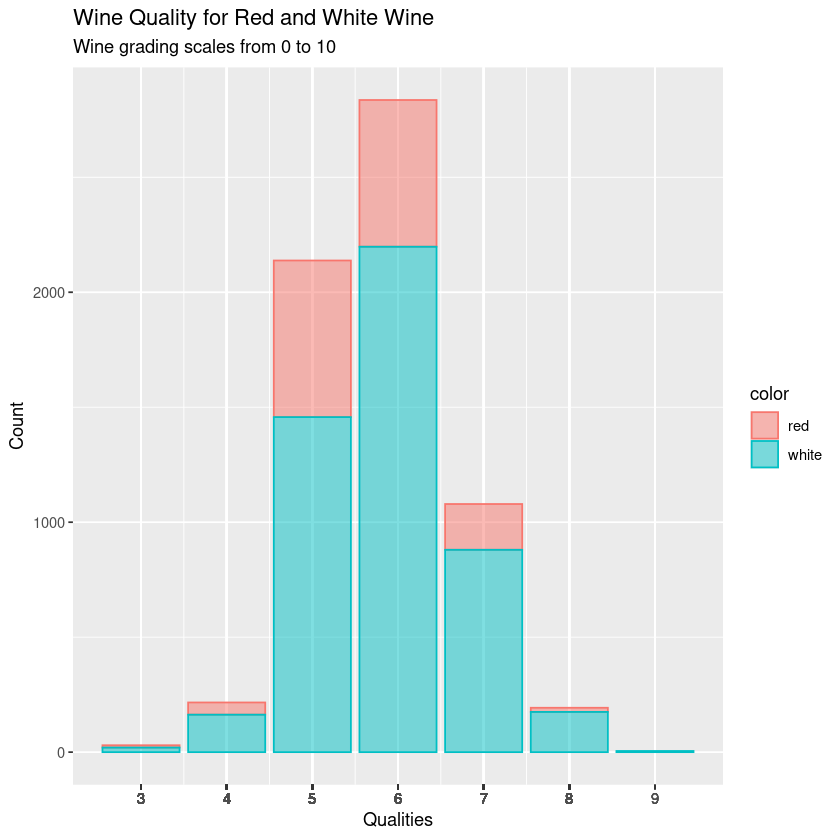

In [10]:
## Plot the grading distribution
wineQuality %>%
    ggplot(aes(x = quality, color = color, fill = color)) +
    geom_bar(alpha = 0.5) +
    labs(title = "Wine Quality for Red and White Wine",
         subtitle = "Wine grading scales from 0 to 10",
        x = "Qualities",
        y = "Count")+
    scale_x_continuous(labels=as.character(wineQuality$quality),breaks=wineQuality$quality)

A histrogram of graded wine quality (scaled from 0 to 10), which is the focus of this analysis, is plotted to visualized wineQuality data. From the figure, we can Identified that white wine, colored blue, made up the majority of the wine dataset. Also, graded wine quality of 0 to 2 and 10 are missing from the data. Additionally, the majority of the data are 5 and 6 graded wine, wine graded less than 4 and more than 8 take the miniority of the data.

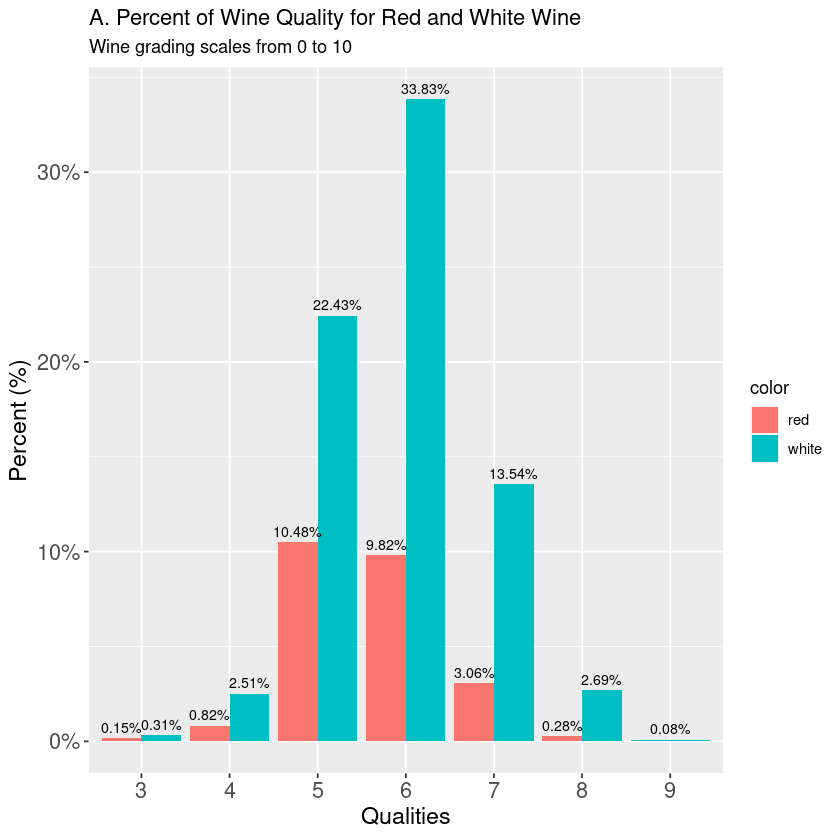

In [11]:
## Ploting as percentage
wineQuality %>% 
    count(color = factor(color), quality = factor(quality)) %>%
    mutate(pct = prop.table(n)) %>%
    ggplot(aes(x = quality, y = pct, 
               fill = color, 
               label = scales::percent(pct, accuracy = 0.01))) +
    geom_col(position = "dodge") + 
    geom_text(position = position_dodge(width = 0.9),
             vjust = -0.5,
             size = 3) + 
    labs(title = "A. Percent of Wine Quality for Red and White Wine",
         subtitle = "Wine grading scales from 0 to 10",
        x = "Qualities",
        y = "Percent (%)")+
    scale_y_continuous(labels = scales::percent)+ 
    theme(axis.text=element_text(size=13),
        axis.title=element_text(size=14))

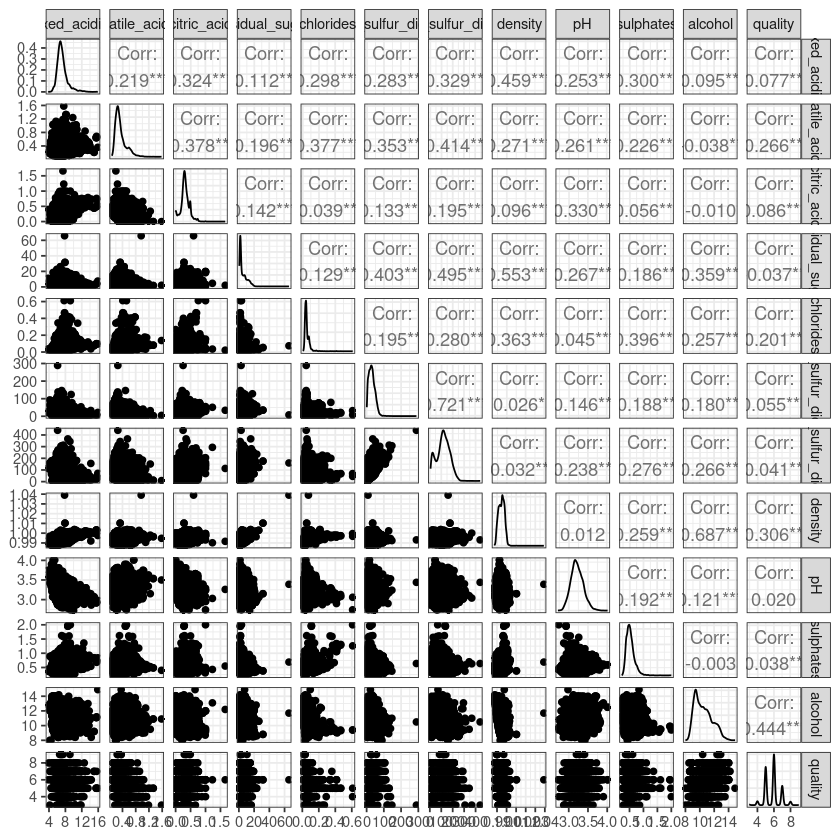

In [12]:
## Pairs plot for every quality except the wine
wineQuality %>% 
    select(-color) %>%
    ggpairs() + theme_bw()

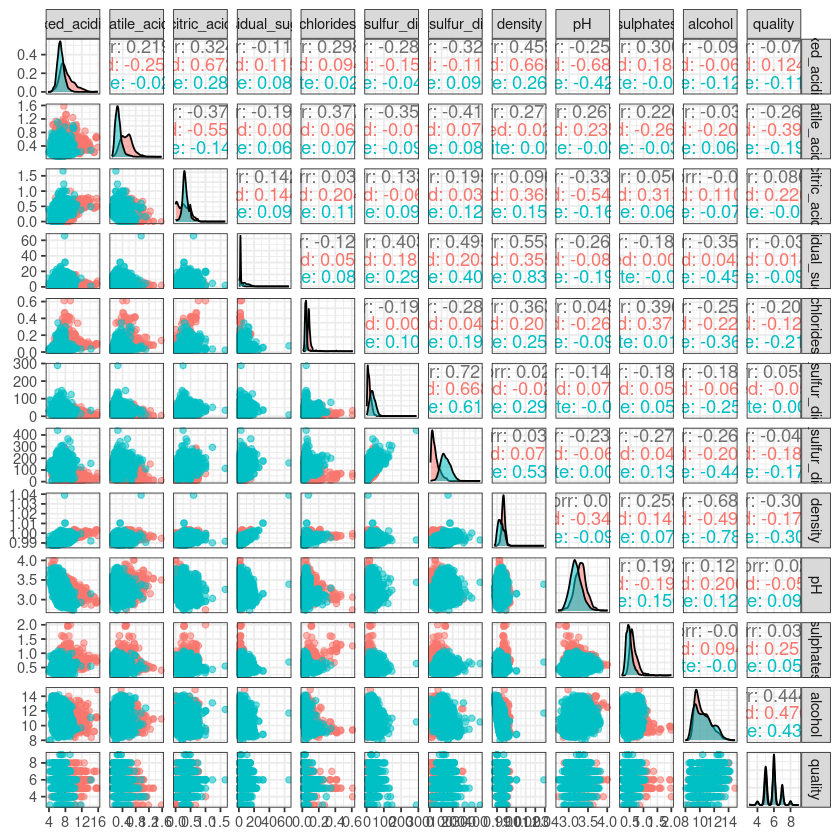

In [13]:
wineQuality %>% 
    ggpairs(aes(color=factor(color), alpha = 0.5), columns=1:12)+
    theme_bw()

In [50]:
## Change into categorical data
break_points <- c(0, 4, 6, 10)
categories_name <- c("0-4", "5-6", "7-10") # Bad - Average - Good
wine_categories <- wineQuality %>%
              mutate(quality_range = cut(wineQuality$quality, breaks = break_points, 
                                         labels = categories_name, include.lowest=TRUE))
head(wine_categories)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color,quality_range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<fct>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red,5-6
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5,red,5-6
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5,red,5-6
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6,red,5-6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5,red,5-6
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5,red,5-6


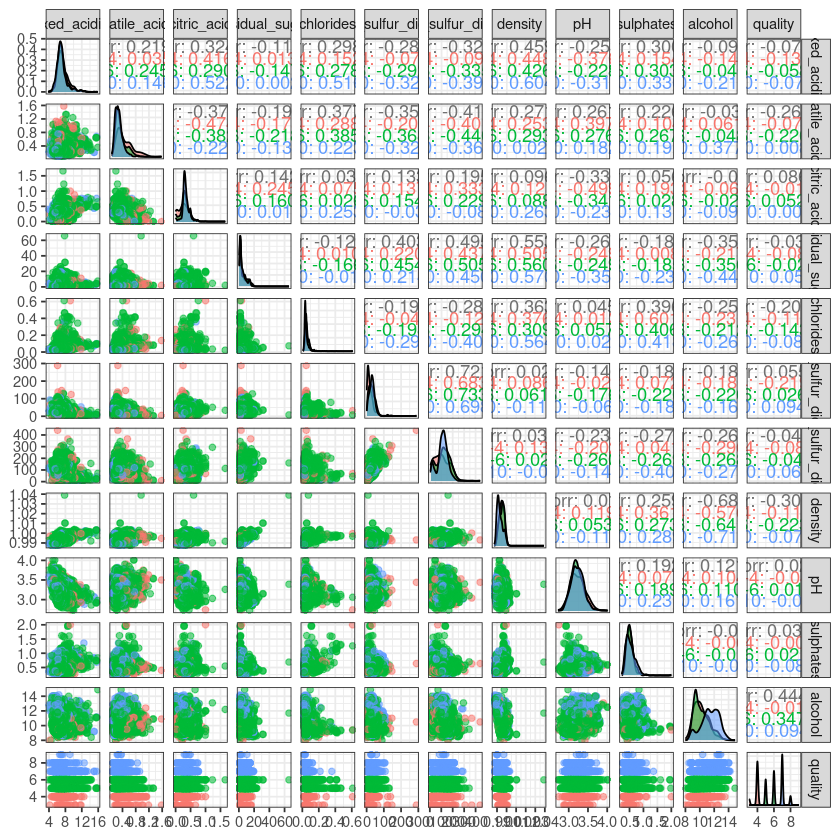

In [15]:
wine_categories %>% 
    ggpairs(aes(color=factor(quality_range), alpha = 0.50), columns=1:12)+
    theme_bw()

corrplot 0.92 loaded



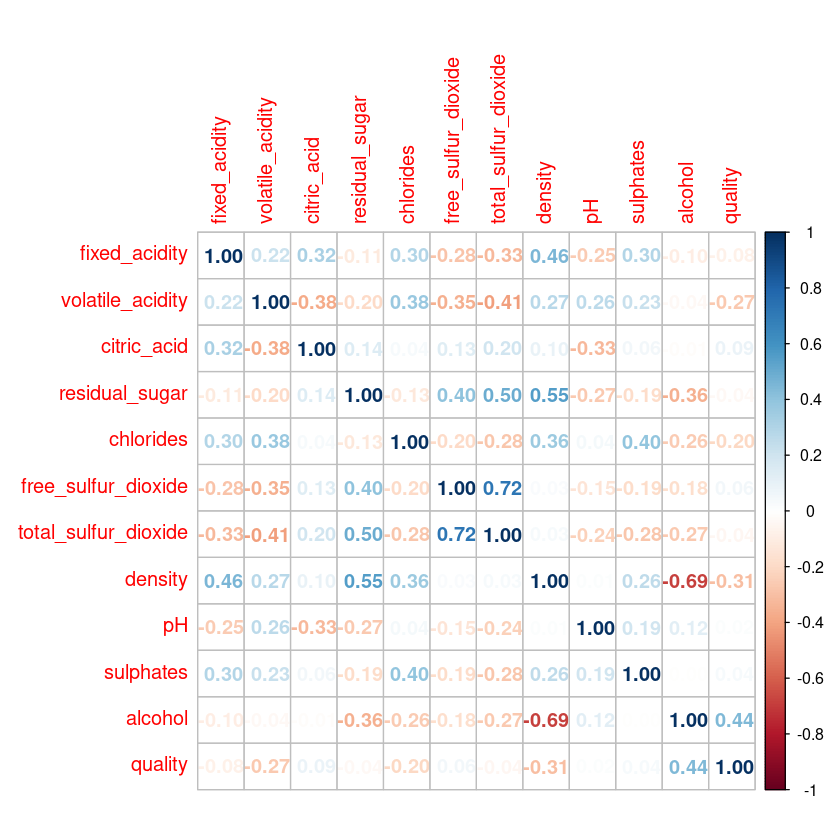

In [16]:
## Corr plot
library(corrplot)
corr_val <- cor(select(wine_categories, 1:12))
# corrplot.mixed(corr_val, upper = "ellipse", lower = "number") 
corrplot(corr_val, method = "number")

In [17]:
## Set as category to make summary count
wine_categories$quality <- as.factor(wine_categories$quality)

In [18]:
## Creating a summary after 
summary(wine_categories)

 fixed_acidity    volatile_acidity  citric_acid     residual_sugar  
 Min.   : 3.800   Min.   :0.0800   Min.   :0.0000   Min.   : 0.600  
 1st Qu.: 6.400   1st Qu.:0.2300   1st Qu.:0.2500   1st Qu.: 1.800  
 Median : 7.000   Median :0.2900   Median :0.3100   Median : 3.000  
 Mean   : 7.215   Mean   :0.3397   Mean   :0.3186   Mean   : 5.443  
 3rd Qu.: 7.700   3rd Qu.:0.4000   3rd Qu.:0.3900   3rd Qu.: 8.100  
 Max.   :15.900   Max.   :1.5800   Max.   :1.6600   Max.   :65.800  
                                                                    
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density      
 Min.   :0.00900   Min.   :  1.00      Min.   :  6.0        Min.   :0.9871  
 1st Qu.:0.03800   1st Qu.: 17.00      1st Qu.: 77.0        1st Qu.:0.9923  
 Median :0.04700   Median : 29.00      Median :118.0        Median :0.9949  
 Mean   :0.05603   Mean   : 30.53      Mean   :115.7        Mean   :0.9947  
 3rd Qu.:0.06500   3rd Qu.: 41.00      3rd Qu.:156.0        3rd

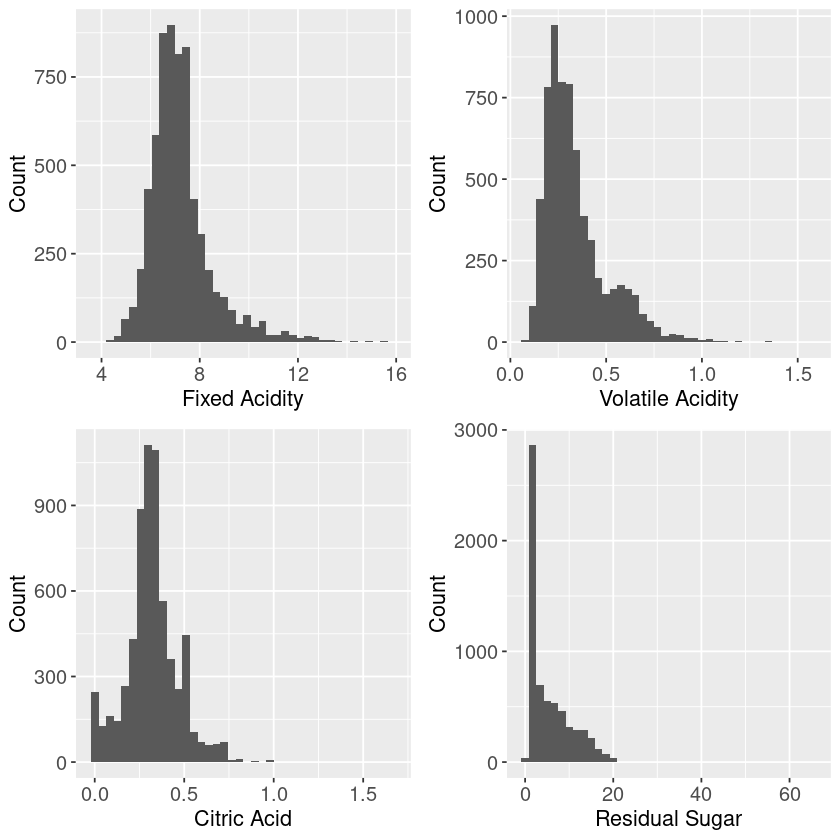

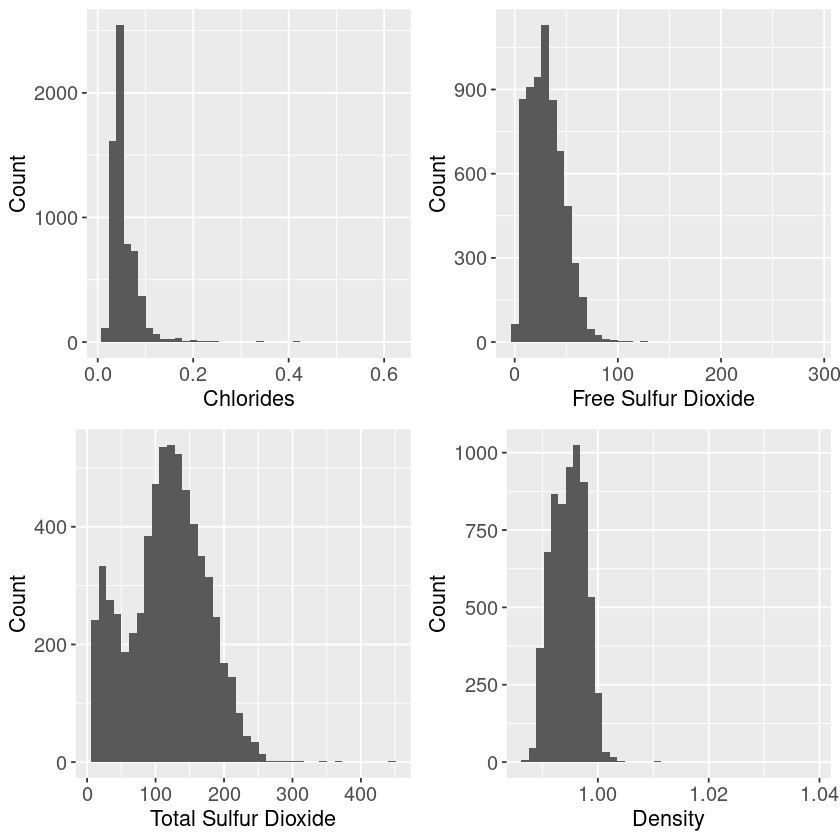

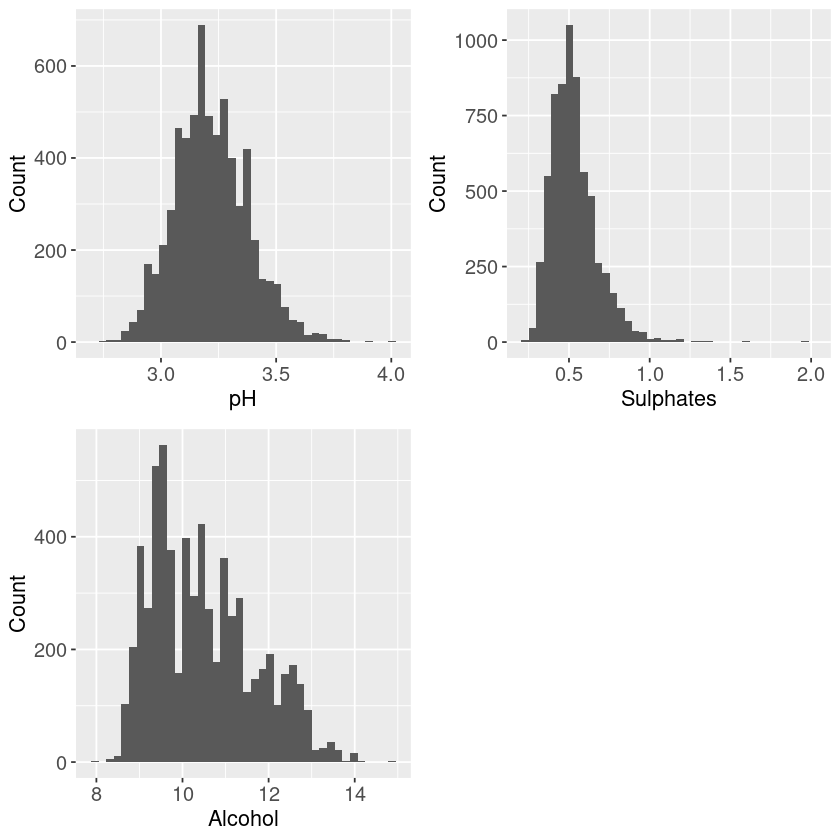

In [49]:
## Histogram Plot
fx_acid_his <- ggplot(wine_categories, aes(x = fixed_acidity)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Fixed Acidity", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

vol_acid_his <- ggplot(wine_categories, aes(x = volatile_acidity)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Volatile Acidity", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

cit_acid_his <- ggplot(wine_categories, aes(x = citric_acid)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Citric Acid", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

res_sug_his <- ggplot(wine_categories, aes(x = residual_sugar)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Residual Sugar", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

cholor_his <- ggplot(wine_categories, aes(x = chlorides)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Chlorides", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

free_sf_his <- ggplot(wine_categories, aes(x = free_sulfur_dioxide)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Free Sulfur Dioxide", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

tot_sf_his <- ggplot(wine_categories, aes(x = total_sulfur_dioxide)) + 
                geom_histogram( bins = 40 )  +
                labs(x = "Total Sulfur Dioxide", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

densi_his <- ggplot(wine_categories, aes(x = density)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Density", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

ph_his <- ggplot(wine_categories, aes(x = pH)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "pH", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

sulf_his <- ggplot(wine_categories, aes(x = sulphates)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Sulphates", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

alc_his <- ggplot(wine_categories, aes(x = alcohol)) + 
                geom_histogram( bins = 40 ) +
                labs(x = "Alcohol", 
                     y = "Count") + 
               theme(legend.position = 'none', 
                plot.title = element_text(hjust=0.5),
                axis.text=element_text(size=12),
                axis.title=element_text(size=13))

ggarrange(fx_acid_his, vol_acid_his, 
          cit_acid_his, res_sug_his, 
          nrow = 2, ncol = 2)

ggarrange(cholor_his, free_sf_his, 
          tot_sf_his, densi_his, 
          nrow = 2, ncol = 2)

ggarrange(ph_his, sulf_his, 
          alc_his,
          nrow = 2, ncol = 2)

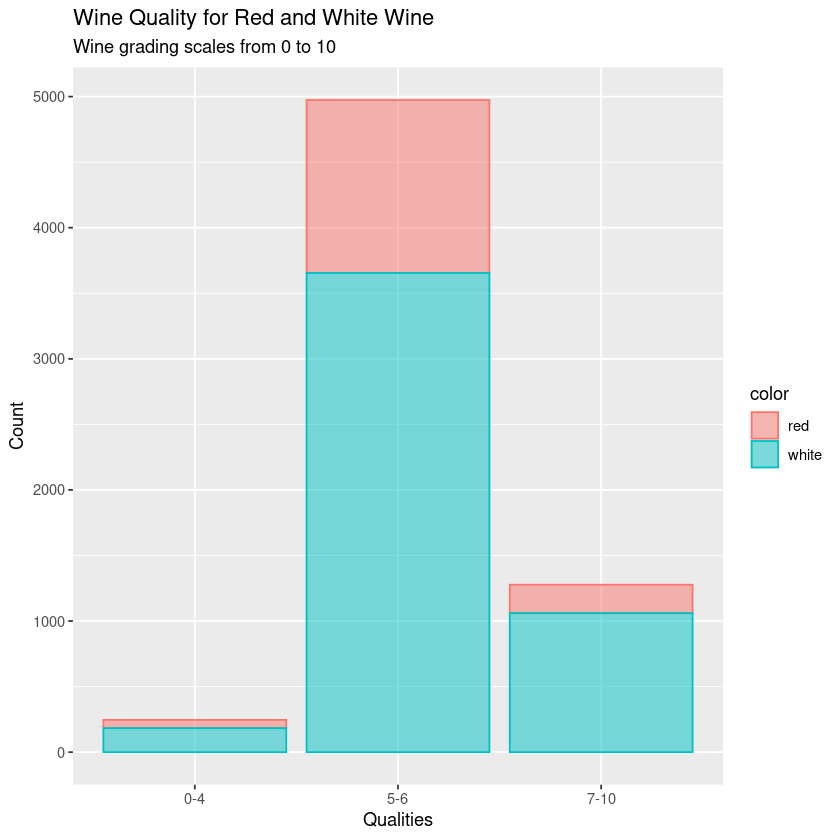

In [20]:
## Histogram plot for the defined range
wine_categories %>%
    ggplot(aes(x = quality_range, color = color, fill = color)) +
    geom_bar(alpha = 0.5) +
    labs(title = "Wine Quality for Red and White Wine",
         subtitle = "Wine grading scales from 0 to 10",
        x = "Qualities",
        y = "Count")

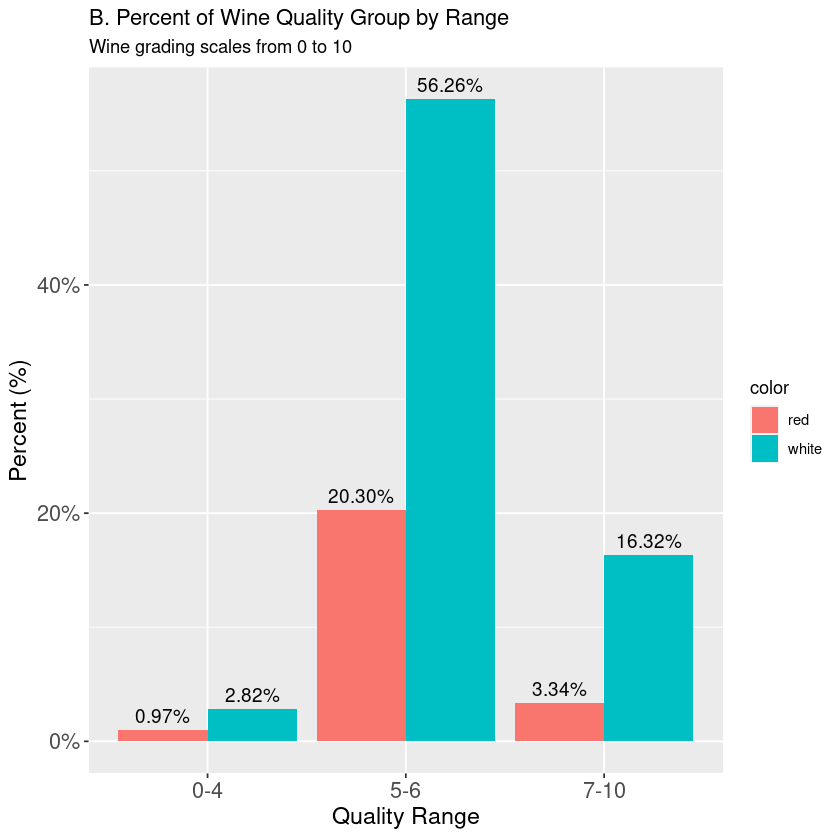

In [21]:
## Histogram plot for the defined range
wine_categories %>% 
    count(color = factor(color), 
          quality_range = factor(quality_range)) %>%
    mutate(pct = prop.table(n)) %>%
    ggplot(aes(x = quality_range, y = pct, 
               fill = color, 
               label = scales::percent(pct, accuracy = 0.01))) +
    geom_col(position = "dodge") + 
    geom_text(position = position_dodge(width = 0.9),
             vjust = -0.5,
             size = 4) + 
    labs(title = "B. Percent of Wine Quality Group by Range",
         subtitle = "Wine grading scales from 0 to 10",
        x = "Quality Range",
        y = "Percent (%)")+
    scale_y_continuous(labels = scales::percent)+ 
    theme(axis.text=element_text(size=13),
        axis.title=element_text(size=14))

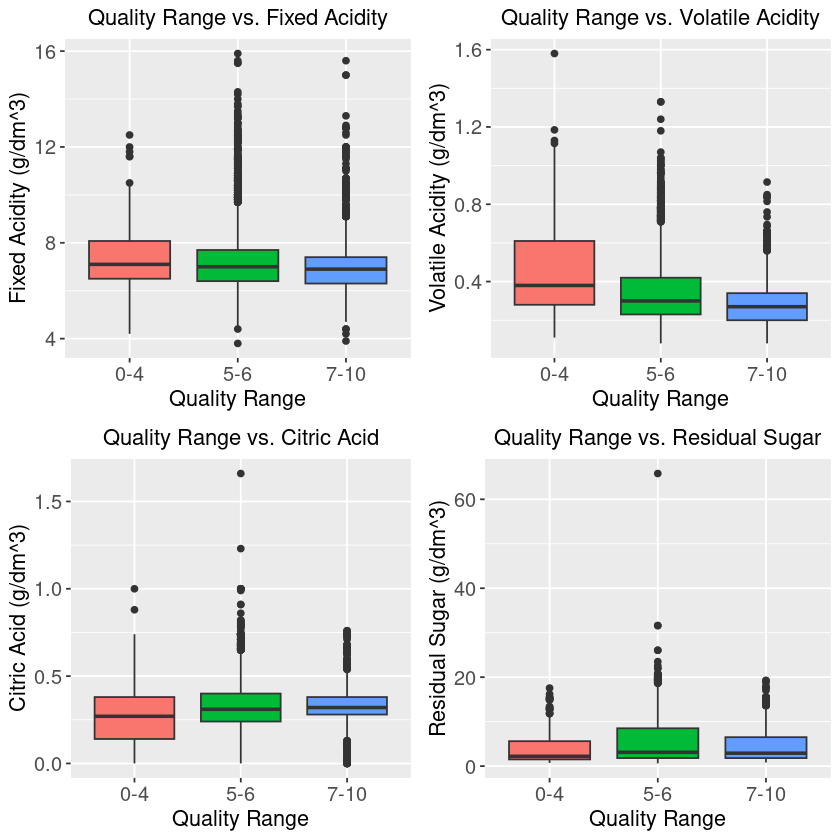

In [22]:
fx_acid_rn <-  ggplot(wine_categories, aes(quality_range, fixed_acidity, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Fixed Acidity", 
       x = "Quality Range", 
       y = "Fixed Acidity (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# fx_acid_rn

vol_acid_rn <-  ggplot(wine_categories, aes(quality_range, volatile_acidity, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Volatile Acidity", 
       x = "Quality Range", 
       y = "Volatile Acidity (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# vol_acid_rn

citric_acid_rn <-  ggplot(wine_categories, aes(quality_range, citric_acid, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Citric Acid", 
       x = "Quality Range", 
       y = "Citric Acid (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# citric_acid_rn

res_sugar_rn <-  ggplot(wine_categories, aes(quality_range, residual_sugar, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Residual Sugar", 
       x = "Quality Range", 
       y = "Residual Sugar (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# res_sugar_rn

## Plot 4 plots
ggarrange(fx_acid_rn, vol_acid_rn, 
          citric_acid_rn, res_sugar_rn, 
          nrow = 2, ncol = 2)

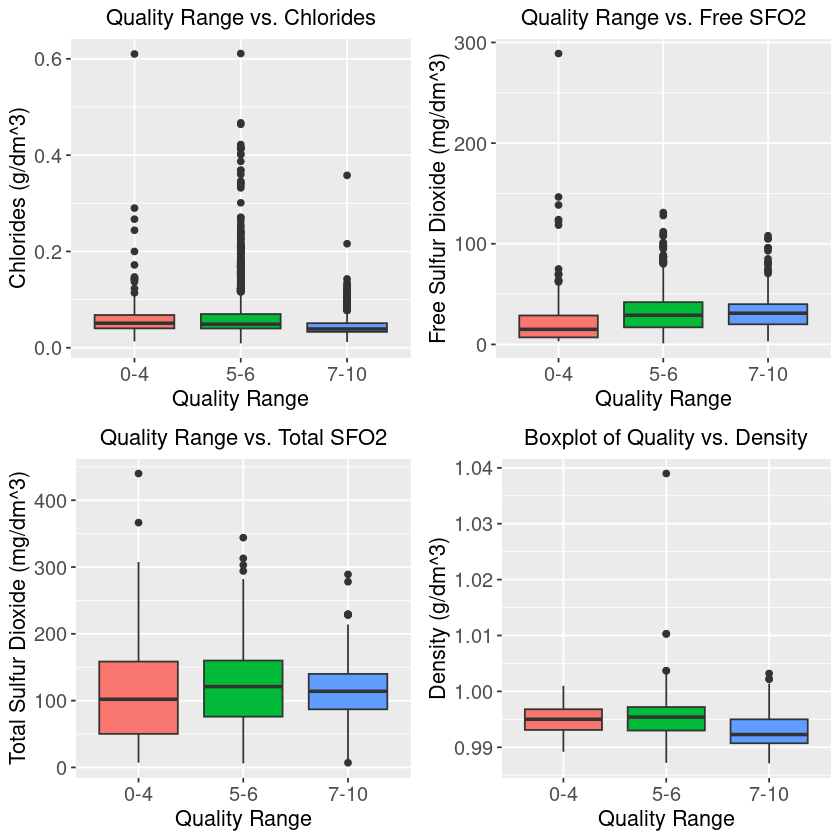

In [23]:
chlor_rn <-  ggplot(wine_categories, aes(quality_range, chlorides, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Chlorides", 
       x = "Quality Range", 
       y = "Chlorides (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# chlor_rn

free_sf_rn <-  ggplot(wine_categories, aes(quality_range, free_sulfur_dioxide, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Free SFO2", 
       x = "Quality Range", 
       y = "Free Sulfur Dioxide (mg/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# free_sf_rn

tot_sf_rn <-  ggplot(wine_categories, aes(quality_range, total_sulfur_dioxide, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Total SFO2", 
       x = "Quality Range", 
       y = "Total Sulfur Dioxide (mg/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# tot_sf_rn

density <-  ggplot(wine_categories, aes(quality_range, density, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Boxplot of Quality vs. Density", 
       x = "Quality Range", 
       y = "Density (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# density

## Plot 4 plots
ggarrange(chlor_rn, free_sf_rn,  
          tot_sf_rn, density, 
          nrow = 2, ncol = 2)

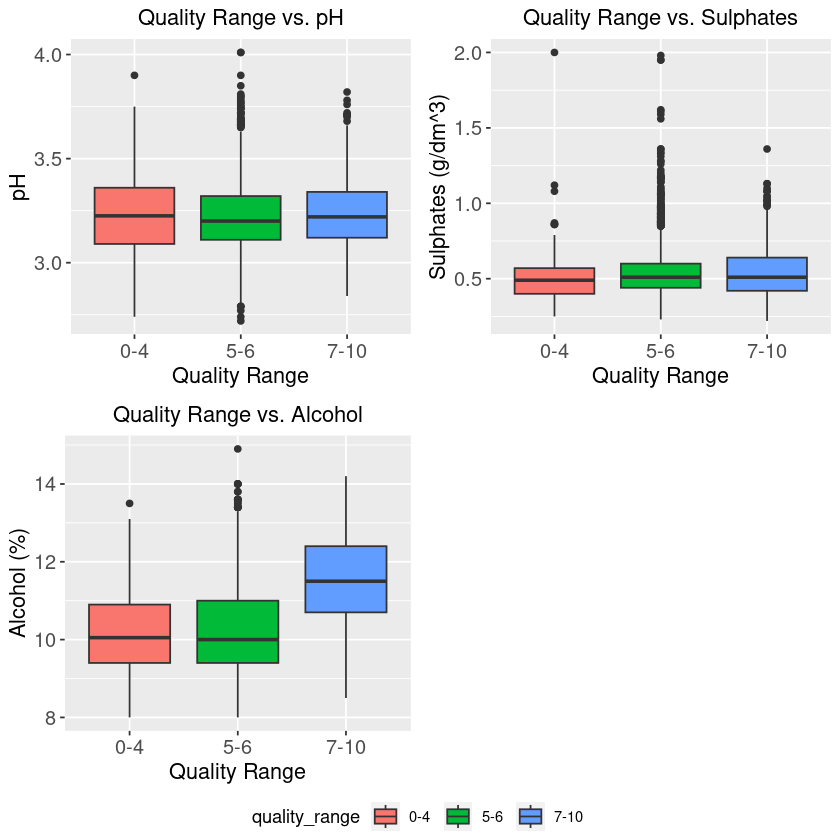

In [24]:
ph_rn <-  ggplot(wine_categories, aes(quality_range, pH, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. pH", 
       x = "Quality Range", 
       y = "pH") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# chlor_rn

sul_rn <-  ggplot(wine_categories, aes(quality_range, sulphates, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Sulphates", 
       x = "Quality Range", 
       y = "Sulphates (g/dm^3)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# sul_rn

alc_rn <-  ggplot(wine_categories, aes(quality_range, alcohol, fill=quality_range)) + 
  geom_boxplot() +
  labs(title = "Quality Range vs. Alcohol", 
       x = "Quality Range", 
       y = "Alcohol (%)") + 
  theme(legend.position = 'none', 
        plot.title = element_text(hjust=0.5),
        axis.text=element_text(size=12),
        axis.title=element_text(size=13))
# alc_rn

## Plot 4 plots
ggarrange(ph_rn, sul_rn, alc_rn, 
          nrow =2, ncol = 2,
          common.legend = TRUE, legend="bottom")

## Supervised Machine Learning

### Premodeling Process

In [51]:
## Removing Quality Column from the model
wine_categories <- wine_categories[, -which(names(wine_categories) == "quality")]
head(wine_categories)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color,quality_range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
1,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,red,5-6
2,7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,red,5-6
3,7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,red,5-6
4,11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,red,5-6
5,7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,red,5-6
6,7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,red,5-6


In [52]:
set.seed(42) # reproducibility
shuff_wineCtg <- wine_categories[sample(1:nrow(wine_categories)),]
shuff_wineCtg$color <- as.factor(shuff_wineCtg$color)  # Shuffle the dataset
head(shuff_wineCtg)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color,quality_range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
2609,8.3,0.15,0.39,1.3,0.055,32,146,0.99300,3.08,0.39,10.5,white,5-6
4069,6.8,0.34,0.10,1.4,0.049,29,118,0.99360,3.21,0.41,9.5,white,5-6
2369,6.7,0.11,0.34,8.8,0.043,41,113,0.99620,3.42,0.40,9.3,white,7-10
5273,5.4,0.30,0.30,1.2,0.029,25,93,0.98742,3.31,0.40,13.6,white,7-10
1098,8.6,0.52,0.38,1.5,0.096,5,18,0.99666,3.20,0.52,9.4,red,5-6
1252,7.5,0.58,0.14,2.2,0.077,27,60,0.99630,3.28,0.59,9.8,red,5-6


In [53]:
## Train and Test Split
## We define it here to have the same data set to create both ML function to better compare it
set.seed(42)
## Although Sample works, the imbalance between red and white wine could result in biased sampling
# idx <- sample(1:nrow(shuff_wineCtg), size = nrow(shuff_wineCtg)*0.3) # getting 30 %

## We will be using this funciton to maintain the overall distribution of the samples
idx <- createDataPartition(shuff_wineCtg$quality_range, 
                           p = 0.7, # percentage of data for training
                           list=FALSE) 
train_wine <- shuff_wineCtg[idx, ] # 70% for training
test_wine <- shuff_wineCtg[-idx, ] # 30% for testing
dim(train_wine)
dim(test_wine)

[1] 4549   13

[1] 1948   13

In [54]:
summary(test_wine) # We have all quality range within the testing group

 fixed_acidity    volatile_acidity  citric_acid     residual_sugar  
 Min.   : 4.200   Min.   :0.0800   Min.   :0.0000   Min.   : 0.700  
 1st Qu.: 6.400   1st Qu.:0.2300   1st Qu.:0.2500   1st Qu.: 1.800  
 Median : 7.000   Median :0.3000   Median :0.3100   Median : 2.900  
 Mean   : 7.245   Mean   :0.3428   Mean   :0.3213   Mean   : 5.378  
 3rd Qu.: 7.700   3rd Qu.:0.4100   3rd Qu.:0.4000   3rd Qu.: 8.100  
 Max.   :15.900   Max.   :1.0900   Max.   :1.2300   Max.   :31.600  
   chlorides       free_sulfur_dioxide total_sulfur_dioxide    density      
 Min.   :0.01200   Min.   :  3.00      Min.   :  6.00       Min.   :0.9871  
 1st Qu.:0.03800   1st Qu.: 17.00      1st Qu.: 76.75       1st Qu.:0.9923  
 Median :0.04700   Median : 29.00      Median :117.00       Median :0.9949  
 Mean   :0.05545   Mean   : 30.42      Mean   :115.18       Mean   :0.9947  
 3rd Qu.:0.06600   3rd Qu.: 41.00      3rd Qu.:155.00       3rd Qu.:0.9970  
 Max.   :0.61100   Max.   :289.00      Max.   :440.00  

In [56]:
## To balance the data we will explore up and down sampling
set.seed(42)
train_wine_up <- upSample(x = train_wine[, -13], 
                          y = train_wine$quality_range,
                          yname = "quality_range")
train_wine_up <- train_wine_up[sample(nrow(train_wine_up)), ] # Shuffle Again
# head(train_wine_up)
dim(train_wine_up)
head(train_wine_up)

[1] 10446    13

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,color,quality_range
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>
3589,7.9,0.20,0.49,1.6,0.053,15,144,0.99300,3.16,0.47,10.5,white,5-6
8688,6.0,0.24,0.27,1.9,0.048,40,170,0.99380,3.64,0.54,10.0,white,7-10
2118,5.3,0.30,0.20,1.1,0.077,48,166,0.99440,3.30,0.54,8.7,white,0-4
6770,8.5,0.19,0.48,1.1,0.026,23,58,0.99184,2.90,0.50,10.5,white,5-6
9923,6.8,0.13,0.39,1.4,0.034,19,102,0.99121,3.23,0.60,11.3,white,7-10
10139,7.2,0.25,0.28,14.4,0.055,55,205,0.99860,3.12,0.38,9.0,white,7-10


### List 1: 
- Option 1.1: Ridge, lasso, or elastic net regression with suitable values for tuning parameters
- <mark> Option 1.2 - Classification and Regression Trees (CART) with Appropiate Pruning </mark>

#### Upsampling Tree Model

In [30]:
## Up Sample Model
set.seed(42)
tree_wine_up <- rpart(data = train_wine_up,
                 quality_range ~ ., # Select every variables
                 method = "class") # Classificaiton

In [31]:
tree_wine_up

n= 10446 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 10446 6964 0-4 (0.33333333 0.33333333 0.33333333)  
   2) alcohol< 10.625 5496 3112 5-6 (0.42230713 0.43377001 0.14392285)  
     4) volatile_acidity>=0.2675 3557 1697 0-4 (0.52291257 0.41495642 0.06213101)  
       8) residual_sugar< 1.55 760  179 0-4 (0.76447368 0.19210526 0.04342105) *
       9) residual_sugar>=1.55 2797 1467 5-6 (0.45727565 0.47550947 0.06721487)  
        18) sulphates< 0.545 1624  730 0-4 (0.55049261 0.42795567 0.02155172)  
          36) free_sulfur_dioxide< 23.5 775  213 0-4 (0.72516129 0.27483871 0.00000000) *
          37) free_sulfur_dioxide>=23.5 849  367 5-6 (0.39104829 0.56772674 0.04122497)  
            74) sulphates>=0.535 109   18 0-4 (0.83486239 0.16513761 0.00000000) *
            75) sulphates< 0.535 740  276 5-6 (0.32567568 0.62702703 0.04729730) *
        19) sulphates>=0.545 1173  538 5-6 (0.32821824 0.54134697 0.13043478)  
          38) citric_acid>=0.455 3

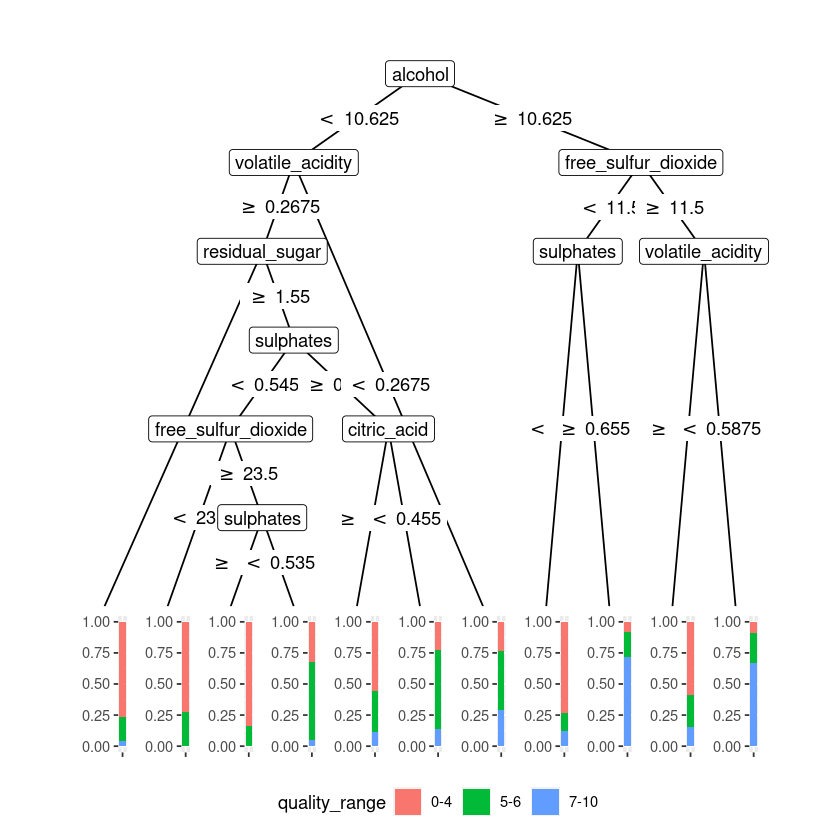

In [32]:
# plot(as.party(tree_wine_up))
autoplot(as.party(tree_wine_up))

In [33]:
printcp(tree_wine_up)


Classification tree:
rpart(formula = quality_range ~ ., data = train_wine_up, method = "class")

Variables actually used in tree construction:
[1] alcohol             citric_acid         free_sulfur_dioxide
[4] residual_sugar      sulphates           volatile_acidity   

Root node error: 6964/10446 = 0.66667

n= 10446 

        CP nsplit rel error  xerror      xstd
1 0.228748      0   1.00000 1.02470 0.0068282
2 0.059449      1   0.77125 0.77125 0.0073352
3 0.055141      2   0.71180 0.70290 0.0073237
4 0.020534      3   0.65666 0.65681 0.0072813
5 0.017949      4   0.63613 0.62780 0.0072401
6 0.015796      7   0.57869 0.60454 0.0071988
7 0.011631      8   0.56289 0.56778 0.0071183
8 0.010482      9   0.55126 0.55256 0.0070793
9 0.010000     10   0.54078 0.55428 0.0070839


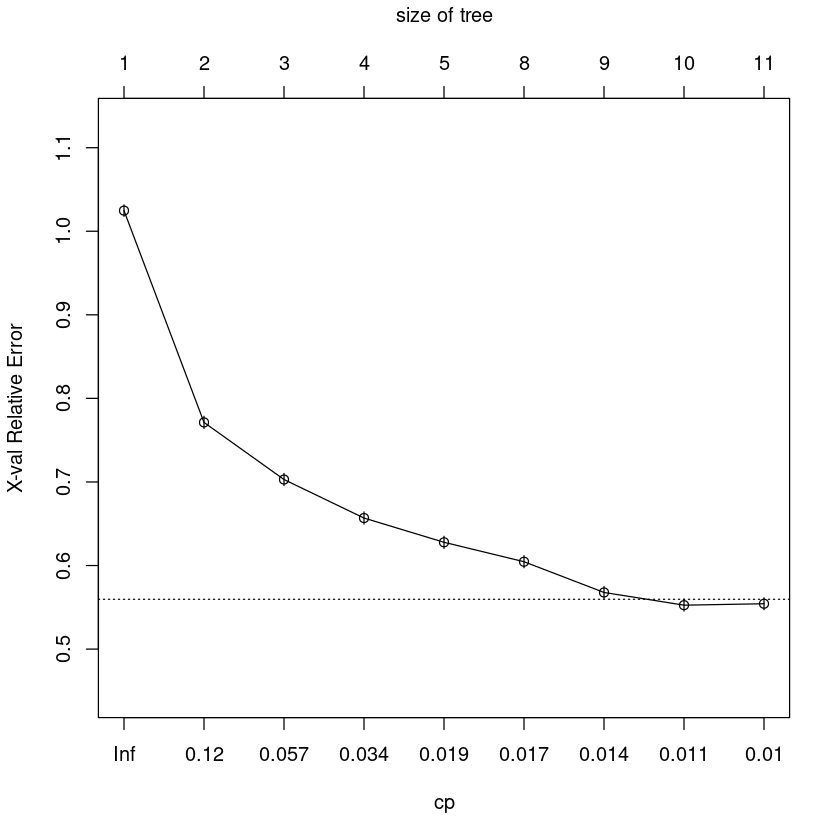

In [34]:
plotcp(tree_wine_up)

In [35]:
## Prune the model
## Our focus is on prediction
## Select lowest corss-validation error
cp <- tree_wine_up$cptable %>%
                      as.data.frame %>%
                      slice(which.min(xerror)) %>%
                      select(CP) %>%
                      as.numeric
pruned_tree_wine = prune(tree_wine_up, cp)

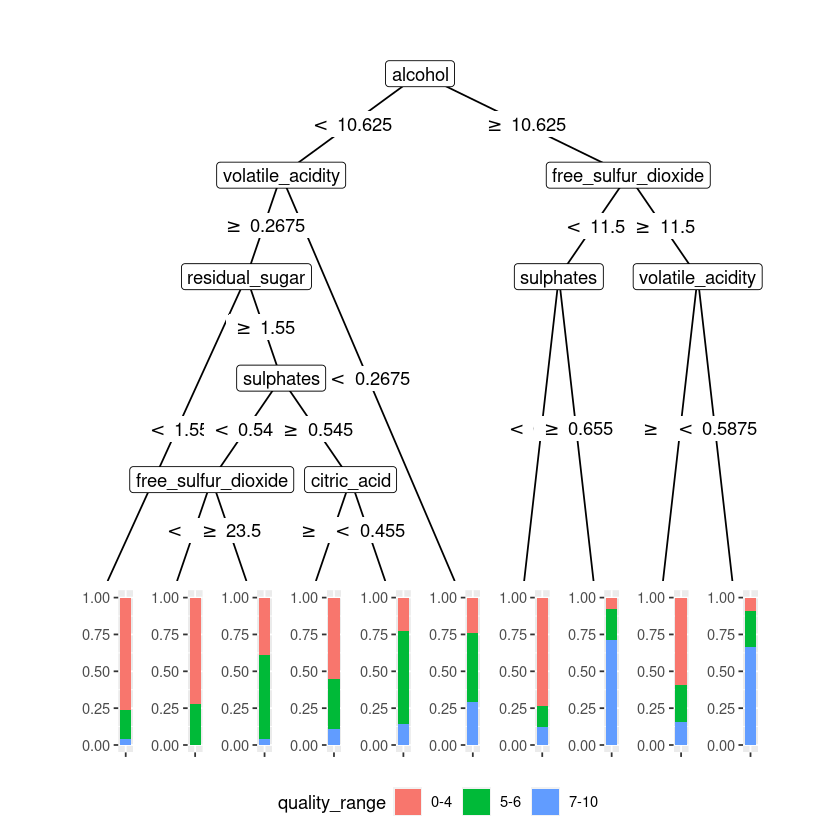

In [36]:
autoplot(as.party(pruned_tree_wine))

In [37]:
## Checking Testing Error
pred_wine <- predict(pruned_tree_wine, 
                    newdata = test_wine, 
                    type="class")

In [38]:
confusionMatrix(pred_wine, as.factor(test_wine$quality_range), mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction 0-4 5-6 7-10
      0-4   37 285   25
      5-6   30 794   91
      7-10   6 413  267

Overall Statistics
                                          
               Accuracy : 0.5637          
                 95% CI : (0.5413, 0.5858)
    No Information Rate : 0.7659          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2268          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 0-4 Class: 5-6 Class: 7-10
Sensitivity             0.50685     0.5322      0.6971
Specificity             0.83467     0.7346      0.7323
Pos Pred Value          0.10663     0.8678      0.3892
Neg Pred Value          0.97751     0.3243      0.9081
Precision               0.10663     0.8678      0.3892
Recall                  0.50685     0.5322      0.6971
F1                      0.17619     

#### Upsampling Tree with Caret

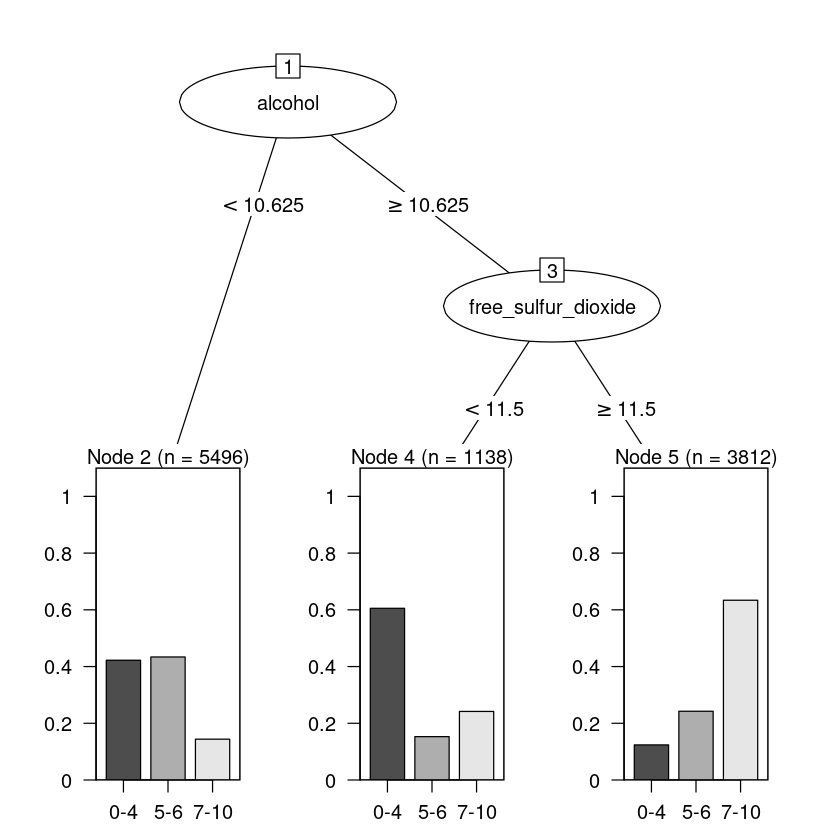

In [39]:
# Load the necessary library for plotting decision trees
fitControl <- trainControl(method = "cv",
                           number = 10)
                       
set.seed(42)
caret_wine_up <- train(factor(quality_range) ~ .,
                  data = train_wine_up,
                  method = "rpart",
                  trControl = fitControl)

# Plot the decision tree
plot(as.party(caret_wine_up$finalModel))

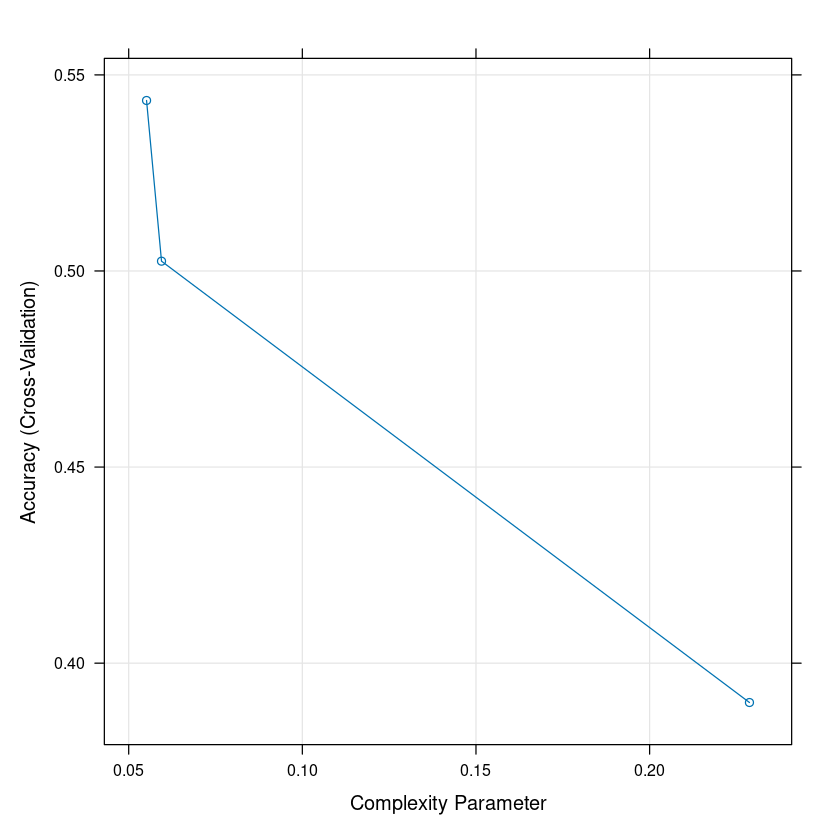

In [40]:
plot(caret_wine_up)

In [41]:
print(caret_wine_up$finalModel)
cat('\n')
print(caret_wine_up$finalModel$variable.importance) # print used variables
cat('\n')
print(caret_wine_up$finalModel$cptable) 
cat('\n')
print(caret_wine_up)

n= 10446 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

1) root 10446 6964 0-4 (0.3333333 0.3333333 0.3333333)  
  2) alcohol< 10.625 5496 3112 5-6 (0.4223071 0.4337700 0.1439229) *
  3) alcohol>=10.625 4950 2259 7-10 (0.2345455 0.2218182 0.5436364)  
    6) free_sulfur_dioxide< 11.5 1138  449 0-4 (0.6054482 0.1528998 0.2416520) *
    7) free_sulfur_dioxide>=11.5 3812 1396 7-10 (0.1238195 0.2423924 0.6337880) *

             alcohol              density  free_sulfur_dioxide 
           624.91464            388.27516            345.06889 
           chlorides total_sulfur_dioxide       residual_sugar 
           306.47286            297.20592             94.55779 
          colorwhite        fixed_acidity          citric_acid 
            60.03835             58.95659             48.21261 

          CP nsplit rel error
1 0.22874785      0 1.0000000
2 0.05944859      1 0.7712522
3 0.05514072      2 0.7118036

CART 

10446 samples
   12 predictor
    3 classes: '0-

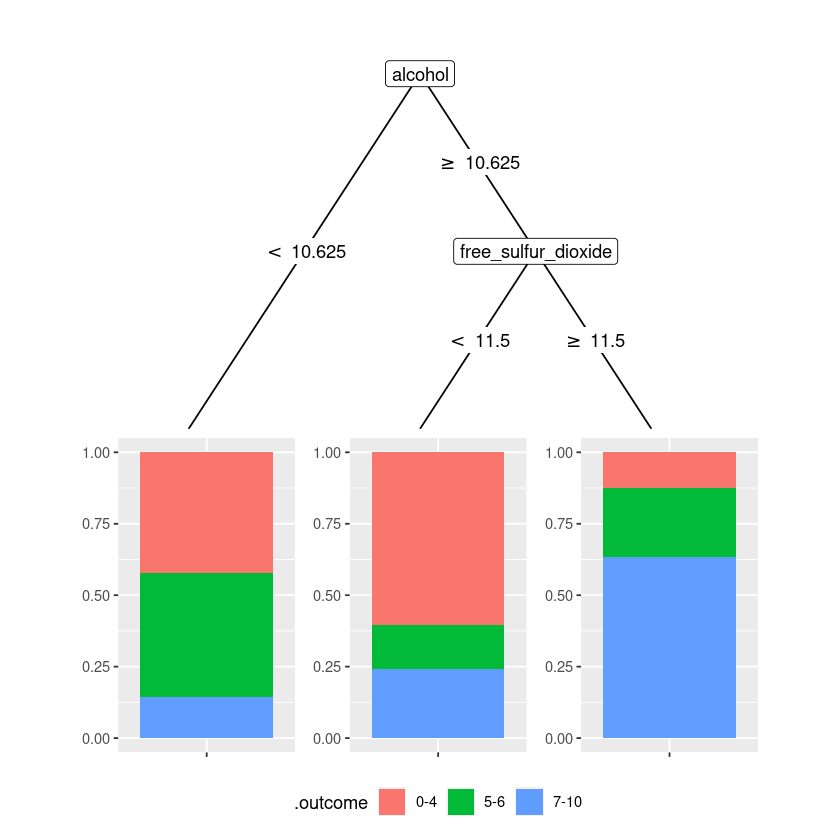

In [42]:
autoplot(as.party(caret_wine_up$finalModel))

In [43]:
pred_wine <- predict(caret_wine_up, newdata = test_wine)
confusionMatrix(pred_wine, as.factor(test_wine$quality_range), mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction  0-4  5-6 7-10
      0-4     9   83   37
      5-6    56 1003   97
      7-10    8  406  249

Overall Statistics
                                          
               Accuracy : 0.6473          
                 95% CI : (0.6256, 0.6686)
    No Information Rate : 0.7659          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2592          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 0-4 Class: 5-6 Class: 7-10
Sensitivity             0.12329     0.6723      0.6501
Specificity             0.93600     0.6645      0.7355
Pos Pred Value          0.06977     0.8676      0.3756
Neg Pred Value          0.96482     0.3826      0.8957
Precision               0.06977     0.8676      0.3756
Recall                  0.12329     0.6723      0.6501
F1                      0.08

#### List 2:
- <mark> Option 1.1 - Creation of a suitable classification or regression model using tree bagging or random forest </mark>
- Option 2.2 - Neural Network with apporpiate number of layers to complete a classification or regression task

In [44]:
## Classification
library(randomForest)
library(rpart)
library(caret)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




#### Upsampling  randomForest Model

In [45]:
set.seed(42)
rf_wine_up <- randomForest(as.factor(quality_range) ~.,
                           data = train_wine_up, 
                           ntree = 1000, 
                           mtry = sqrt(ncol(train_wine_up)))
rf_wine_up


Call:
 randomForest(formula = as.factor(quality_range) ~ ., data = train_wine_up,      ntree = 1000, mtry = sqrt(ncol(train_wine_up))) 
               Type of random forest: classification
                     Number of trees: 1000
No. of variables tried at each split: 4

        OOB estimate of  error rate: 2.42%
Confusion matrix:
      0-4  5-6 7-10 class.error
0-4  3482    0    0 0.000000000
5-6    14 3250  218 0.066628374
7-10    0   21 3461 0.006031017

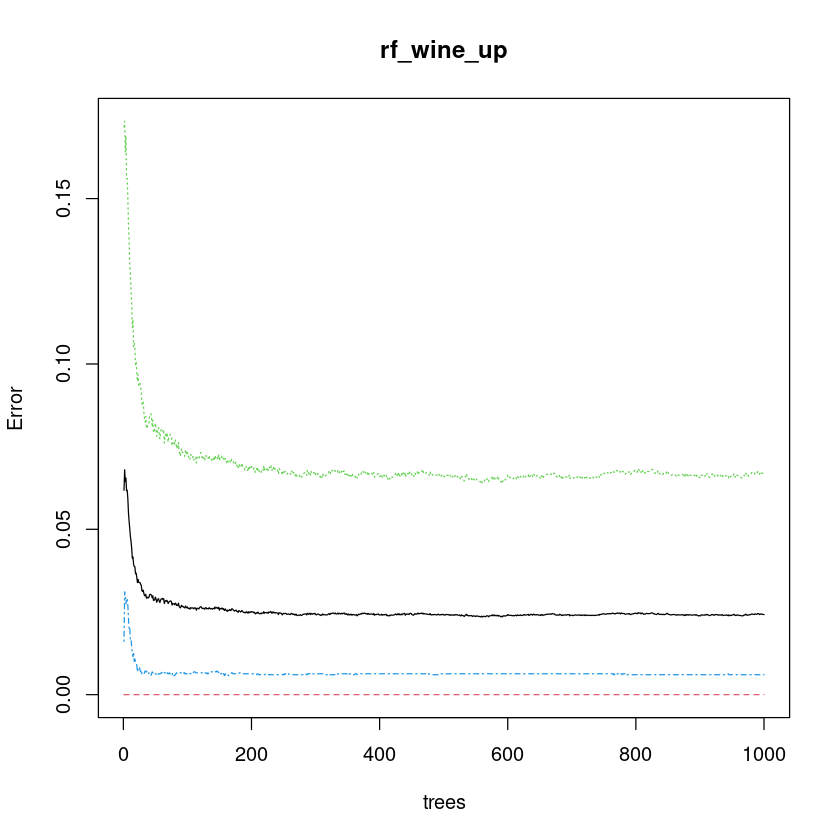

In [46]:
plot(rf_wine_up)

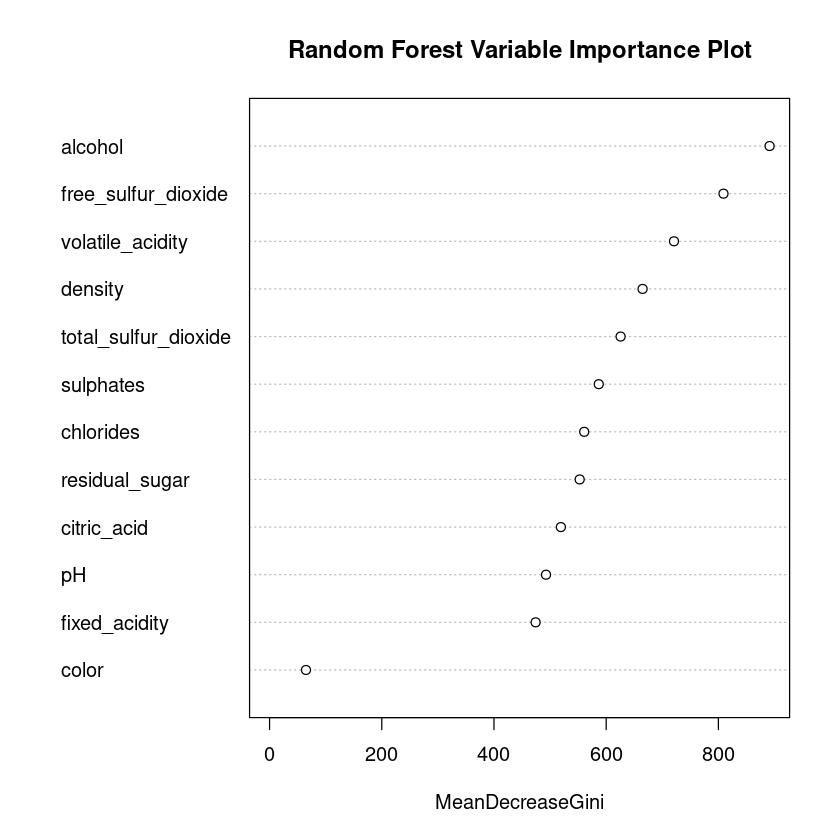

In [47]:
varImpPlot(rf_wine_up,
          main="Random Forest Variable Importance Plot")

In [48]:
# Model Evaluation
pred_rf_up = predict(rf_wine_up, newdata = test_wine, type="class")
confusionMatrix(pred_rf_up, as.factor(test_wine$quality_range), mode = "everything")

Confusion Matrix and Statistics

          Reference
Prediction  0-4  5-6 7-10
      0-4    12    7    0
      5-6    61 1407  136
      7-10    0   78  247

Overall Statistics
                                          
               Accuracy : 0.8552          
                 95% CI : (0.8388, 0.8706)
    No Information Rate : 0.7659          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.5694          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: 0-4 Class: 5-6 Class: 7-10
Sensitivity            0.164384     0.9430      0.6449
Specificity            0.996267     0.5680      0.9502
Pos Pred Value         0.631579     0.8772      0.7600
Neg Pred Value         0.968377     0.7529      0.9162
Precision              0.631579     0.8772      0.7600
Recall                 0.164384     0.9430      0.6449
F1                     0.260